In [11]:
#loading in adjusted array 
!pip install keras.preprocessing


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.0 MB/s eta 0:00:00


In [1]:
# for loading/processing the images  
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input


# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet50 import ResNet50

In [3]:
import numpy as np 
df = np.load('/content/drive/MyDrive/Colab Notebooks/final_array.npy')

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#checking shape of array 
df.shape

(2730, 5, 280, 280, 1)

In [4]:
import numpy as np
data = df
# assume that `data` is a 5D numpy array with shape (n_samples, d1, d2, d3, d4)
print('Original shape:', data.shape)  # prints (2730, 5, 280, 280, 1)

# use numpy.reshape() to combine the first two dimensions along the first axis
data_reshaped = np.reshape(data, (data.shape[0]*data.shape[1], data.shape[2], data.shape[3], data.shape[4]))

# print the new shape
print('New shape:', data_reshaped.shape)  # prints (13650, 280, 280, 1)



Original shape: (2730, 5, 280, 280, 1)
New shape: (13650, 280, 280, 1)


In [4]:
# Repeat single channel 3 times to create 3-channel input
dicom_array = np.repeat(data_reshaped, 3, axis=-1)

In [5]:
#getting final dicom array that is tripled
dicom_array.shape

(13650, 280, 280, 3)

In [8]:
from skimage.transform import resize

# assume that `dicom_array` contains DICOM images with shape `(n_samples, height, width, channels)`
height_new, width_new, channels = (224, 224, 3)  # set the new dimensions
dicom_array_resized = np.zeros((dicom_array.shape[0], height_new, width_new, channels))

# loop over the DICOM images in `dicom_array` and resize each image
for i in range(dicom_array.shape[0]):
    img_resized = resize(dicom_array[i], (height_new, width_new, channels), anti_aliasing=True)
    dicom_array_resized[i] = img_resized


In [11]:
np.save("/content/drive/MyDrive/Colab Notebooks/dicom_resized.npy",dicom_array_resized)

In [3]:
import numpy as np
dicom_array_resized = np.load('/content/drive/MyDrive/Colab Notebooks/dicom_resized.npy')

In [4]:
dicom_array_resized.shape

(13650, 224, 224, 3)

In [4]:
x = preprocess_input(dicom_array_resized)

In [5]:
#adding model to be used 
model = VGG16(
    include_top=False,
    weights='imagenet',
)
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

In [6]:
features = model.predict(dicom_array_resized)
print(features.shape)

427/427 [==============================] - 13s 21ms/step
(13650, 14, 14, 512)


In [9]:
type(features)

numpy.ndarray

In [7]:
np.save("/content/drive/MyDrive/Colab Notebooks/features_2d_VGG16.npy",features)

In [11]:
ap=np.load("/content/drive/MyDrive/Colab Notebooks/features.npy")
ap.shape

(13650, 4096)

Trying to use previous resnet 50 model to fo featur extraction

In [5]:

dicom_array = df
dicom_array = np.repeat(df, 3, axis=-1)
# Parameters
input_shape = (5, 280, 280, 3)

# Load the pre-trained 2D ResNet50 model, excluding the top layer
base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape[1:]
)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = True

# Custom model to handle the 5D input
input_layer = layers.Input(shape=input_shape, name="input")
x = layers.TimeDistributed(base_model)(input_layer)
x = layers.Conv3D(64, kernel_size=(1, 3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling3D(pool_size=(1, 2, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.GlobalAveragePooling3D()(x)
x = layers.Dropout(0.3)(x)

feature_extractor_model = keras.Model(inputs=input_layer, outputs=x)

# Use feature_extractor_model to extract features from input data
features = feature_extractor_model.predict(dicom_array)

# The shape of features will be (n_samples, n_features)
print(features.shape)


86/86 [==============================] - 26s 170ms/step
(2730, 64)


In [6]:
np.save("/content/drive/MyDrive/Colab Notebooks/VGG16_features.npy",features)

Number of clusters: 5


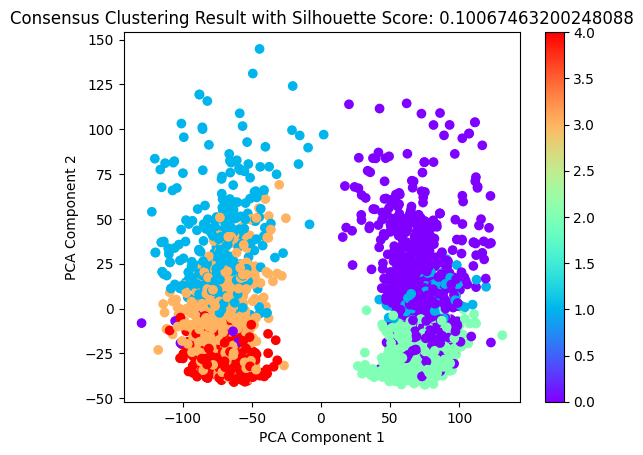

In [ ]:
# compute the consensus clustering solution by majority voting
consensus_labels = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=cluster_labels)

# get the number of clusters
n_clusters = len(np.unique(consensus_labels))
print("Number of clusters:", n_clusters)

# compute the silhouette score
score = silhouette_score(data_transformed, consensus_labels)

# plot the clusters
plt.scatter(data_transformed[:, 0], data_transformed[:, 1], c=consensus_labels, cmap='rainbow')
plt.colorbar()
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Consensus Clustering Result with Silhouette Score: {}'.format(score))
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# assume that `data` is a 5D numpy array with shape (n_samples, d1, d2, d3, d4)

# reshape the 5D array into a 2D array
n_samples = data.shape[0]
n_features = np.prod(data.shape[1:])
data_2d = data.reshape(n_samples, n_features)

# create a PCA object with 15 components
pca = PCA(n_components=15)

# fit the PCA model to the data
data_transformed = pca.fit_transform(data_2d)

# set the number of clustering algorithms to run
n_clustering_algorithms = 10

# create empty list to store cluster labels
cluster_labels = []

# loop over the range of clustering algorithms and compute the cluster labels for each algorithm
for i in range(n_clustering_algorithms):
    # create a KMeans clustering model with a random initialization
    kmeans_model = KMeans(n_clusters=5, init='random')

    # fit the model to the transformed data
    kmeans_model.fit(data_transformed)

    # get the cluster labels for each data point
    labels = kmeans_model.labels_

    # append the cluster labels to the list
    cluster_labels.append(labels)

# compute the consensus clustering solution by majority voting
consensus_labels = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=cluster_labels)

# compute the silhouette score
score = silhouette_score(data_transformed, consensus_labels)

# plot the clusters
plt.scatter(data_transformed[:, 0], data_transformed[:, 1], c=consensus_labels, cmap='rainbow')
plt.colorbar()
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Consensus Clustering Result with Silhouette Score: {}'.format(score))
plt.show()


In [ ]:
# get the cluster labels for each data point
labels = hdbscan_model.labels_

# print the number of clusters
n_clusters = len(set(labels))
print("Number of clusters:", n_clusters)


Number of clusters: 3


**Untuned modeel**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import hdbscan
import numpy as np
import pandas as pd
from tensorflow.keras.applications.resnet50 import ResNet50

# Load the DICOM array (assuming it has shape [num_images, depth, height, width, num_channels])
dicom_array = df
labels = one_hot_encoded_list

# Repeat single channel 3 times to create 3-channel input
dicom_array = np.repeat(dicom_array, 3, axis=-1)

# Convert labels to one-hot encoded vectors
labels = np.asarray(labels)
labels = labels.astype(np.int32)
num_classes = np.max(labels) + 1  # Add 1 to account for 0-indexing
labels_one_hot = tf.keras.utils.to_categorical(labels, num_classes)

# Parameters
input_shape = (5, 280, 280, 3)

# Load the pre-trained 2D ResNet50 model, excluding the top layer
base_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape[1:]
)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = True

# Custom model to handle the 5D input
input_layer = layers.Input(shape=input_shape, name="input")
x = layers.TimeDistributed(base_model)(input_layer)
x = layers.Conv3D(64, kernel_size=(1, 3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling3D(pool_size=(1, 2, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.GlobalAveragePooling3D()(x)
x = layers.Dropout(0.3)(x)
output_layer = layers.Dense(num_classes, activation='softmax', name="output")(x)

# Create the model
model = keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fit the model to the data
model.fit(dicom_array, labels_one_hot, batch_size=18, epochs=10, verbose=1)

# Extract the features using the trained model
features = base_model.predict(dicom_array)

# Cluster the features using HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=2)
cluster_labels = clusterer.fit_predict(features.reshape(features.shape[0], -1))

# Calculate the silhouette score
silhouette_score = hdbscan.approximate_predictive_posterior(
    features.reshape(features.shape[0], -1), clusterer
).mean()

print("Silhouette score:", silhouette_score)




Epoch 1/10
84/84 [==============================] - 74s 320ms/step - loss: 1.3168 - accuracy: 0.3800
Epoch 2/10
84/84 [==============================] - 25s 296ms/step - loss: 1.0835 - accuracy: 0.6107
Epoch 3/10
84/84 [==============================] - 25s 296ms/step - loss: 0.9206 - accuracy: 0.7140
Epoch 4/10
84/84 [==============================] - 25s 296ms/step - loss: 0.7918 - accuracy: 0.7873
Epoch 5/10
84/84 [==============================] - 25s 296ms/step - loss: 0.6730 - accuracy: 0.8420
Epoch 6/10
84/84 [==============================] - 25s 297ms/step - loss: 0.5616 - accuracy: 0.8967
Epoch 7/10
84/84 [==============================] - 25s 297ms/step - loss: 0.4206 - accuracy: 0.9480
Epoch 8/10
84/84 [==============================] - 25s 296ms/step - loss: 0.3172 - accuracy: 0.9740
Epoch 9/10
84/84 [==============================] - 25s 297ms/step - loss: 0.2337 - accuracy: 0.9847
Epoch 10/10
84/84 [==============================] - 25s 296ms/step - loss: 0.1994 - accura

ValueError: ignored

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import numpy as np
import itertools
y_pred = model.predict(X_test)

# Calculate AUC-ROC score
auc = roc_auc_score(y_test, y_pred, multi_class='ovr')

# Calculate confusion matrix
y_true_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Calculate sensitivity and specificity for each class
num_classes = y_test.shape[1]
sensitivity = []
specificity = []
for i in range(num_classes):
    true_positives = cm[i,i]
    false_positives = cm[:,i].sum() - true_positives
    false_negatives = cm[i,:].sum() - true_positives
    true_negatives = cm.sum() - true_positives - false_positives - false_negatives
    
    sensitivity.append(true_positives / (true_positives + false_negatives))
    specificity.append(true_negatives / (true_negatives + false_positives))

# Calculate overall accuracy, sensitivity, specificity, and F1-score
overall_accuracy = accuracy_score(y_true_classes, y_pred_classes)
overall_sensitivity = np.mean(sensitivity)
overall_specificity = np.mean(specificity)
overall_f1_score = f1_score(y_true_classes, y_pred_classes, average='macro')

# Print overall metrics
print(f'Overall Accuracy: {overall_accuracy:.2f}')
print(f'Overall Sensitivity: {overall_sensitivity:.2f}')
print(f'Overall Specificity: {overall_specificity:.2f}')
print(f'Overall F1-score: {overall_f1_score:.2f}')

# Plot ROC curve
class_names = ['Normal', 'Actionable', 'Benign', 'Cancer']
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = roc_auc_score(y_test[:, i], y_pred[:, i])
    plt.plot(fpr[i], tpr[i], label='ROC curve (AUC = %0.2f) for %s' % (roc_auc[i], class_names[i]))

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc="lower right")

plt.show()

# Plot confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Multiclass Classification')
plt.colorbar()

tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

plt.show()

**Tuned model**



In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")

# Load the DICOM array (assuming it has shape [num_images, depth, height, width, num_channels])
dicom_array = df
labels = one_hot_encoded_list

# Repeat single channel 3 times to create 3-channel input
dicom_array = np.repeat(dicom_array, 3, axis=-1)

# Convert labels to one-hot encoded vectors
labels = np.asarray(labels)
labels = labels.astype(np.int32)
num_classes = np.max(labels) + 1  # Add 1 to account for 0-indexing
labels_one_hot = torch.from_numpy(labels).long()  # convert to long tensor
labels_one_hot = nn.functional.one_hot(labels_one_hot, num_classes=num_classes).float()  # apply one_hot() on long tensor and then convert to float tensor


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    dicom_array, labels_one_hot, test_size=0.2, random_state=42, stratify=labels
)

# Parameters
input_shape = (3, 280, 280)

# Load the pre-trained 2D AlexNet model, excluding the top layer
base_model = models.alexnet(pretrained=True)
base_model = nn.Sequential(*list(base_model.children())[:-1])

# Freeze the base model layers
for param in base_model.parameters():
    param.requires_grad = False

# Custom model to handle the 5D input
class AlexNet3D(nn.Module):
    def __init__(self, base_model, num_classes):
        super(AlexNet3D, self).__init__()
        self.base_model = base_model
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(43264, 4096)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(4096, 4096)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(4096, num_classes)
        
    def forward(self, x):
        x = self.base_model(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Create the model
model = AlexNet3D(base_model, num_classes)
model = model.to(device)

# Define the hyperparameter distribution
param_dist = {
    'lr': uniform(0.0001, 0.01),
    'dropout_rate': uniform(0.1, 0.4)
}

from skorch import NeuralNetClassifier

# Wrap the PyTorch model using the Skorch library
skorch_model = NeuralNetClassifier(
    module=model,
    criterion=nn.CrossEntropyLoss,
    optimizer=torch.optim.SGD,
    optimizer__momentum=0.9,
    max_epochs=10,
    batch_size=8,
    device=device
)

# Fit the model with randomized search
random_search = RandomizedSearchCV(
    estimator=skorch_model,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    verbose=1,
    n_jobs=-1
)

random_search.fit(X_train, y_train.argmax(axis=1))


# Print the best hyperparameters
print("Best score: %f using %s" % (random_search.best_score_, random_search.best_params_))

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim




In [ ]:
print(sensitivity)

[0.9482352941176471, 0.05555555555555555, 0.34375, 0.4117647058823529]


In [ ]:
print(specificity)

[0.23140495867768596, 0.9535864978902954, 1.0, 0.9886578449905482]


**bold text**

Tuned model 

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

if tf.test.is_gpu_available():
    print('GPU available:')
    for gpu in tf.config.list_physical_devices('GPU'):
        print(gpu)
    tf.config.set_visible_devices(gpu, 'GPU')
else:
    print('No GPU available.')

dicom_array = df
labels = one_hot_encoded_list
dicom_array = np.repeat(dicom_array, 3, axis=-1)

labels = np.asarray(labels)
labels = labels.astype(np.int32)
num_classes = np.max(labels) + 1
labels_one_hot = tf.keras.utils.to_categorical(labels, num_classes)

X_train, X_test, y_train, y_test = train_test_split(
    dicom_array, labels_one_hot, test_size=0.2, random_state=42, stratify=labels
)
def create_model(learning_rate=1e-5, dropout_rate=0.3):
    input_shape = (5, 280, 280, 3)

    # Load the VGG-16 model
    base_model = VGG16(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape[1:]
    )

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = True

    # Custom model to handle the 5D input
    input_layer = layers.Input(shape=input_shape, name="input")
    x = layers.TimeDistributed(base_model)(input_layer)
    x = layers.Conv3D(64, kernel_size=(1, 3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling3D(pool_size=(1, 2, 2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dropout(dropout_rate)(x)
    output_layer = layers.Dense(num_classes, activation='softmax', name="output")(x)

    # Create the model
    model = keras.Model(inputs=input_layer, outputs=output_layer)

    # Compile the model
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=8, verbose=1)

# Define the hyperparameter grid
param_grid = {
    'learning_rate': [1e-4, 1e-5, 1e-6],
    'dropout_rate': [0.3, 0.4, 0.5]
}

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)

# Fit the model with Grid Search
grid_result = grid.fit(X_train, y_train)

# Print the best hyperparameters
print("Best score: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Train the model with the best hyperparameters on the entire training set
best_learning_rate = grid_result.best_params_['learning_rate']
best_dropout_rate = grid_result.best_params_['dropout_rate']
best_model = create_model(learning_rate=best_learning_rate, dropout_rate=best_dropout_rate)
best_model.fit(X_train, y_train, epochs=10, batch_size=8)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU available:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


<ipython-input-11-e1f0127ac525>:62: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=8, verbose=1)


18/18 [==============================] - 8s 174ms/step
Overall Accuracy: 0.76
Overall Sensitivity: 0.48
Overall Specificity: 0.81
Overall F1-score: 0.53


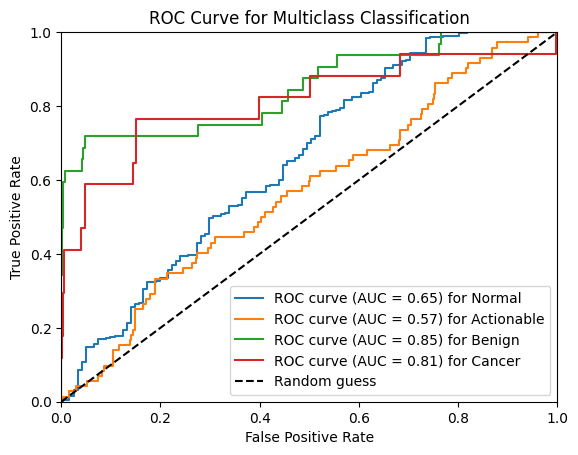

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import numpy as np

y_pred = model.predict(X_test)

auc = roc_auc_score(y_test, y_pred, multi_class='ovr')

y_true_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_true_classes, y_pred_classes)

num_classes = y_test.shape[1]
sensitivity = []
specificity = []
for i in range(num_classes):
    true_positives = cm[i,i]
    false_positives = cm[:,i].sum() - true_positives
    false_negatives = cm[i,:].sum() - true_positives
    true_negatives = cm.sum() - true_positives - false_positives - false_negatives
    
    sensitivity.append(true_positives / (true_positives + false_negatives))
    specificity.append(true_negatives / (true_negatives + false_positives))

# Calculate overall accuracy, sensitivity, specificity, and F1-score
overall_accuracy = accuracy_score(y_true_classes, y_pred_classes)
overall_sensitivity = np.mean(sensitivity)
overall_specificity = np.mean(specificity)
overall_f1_score = f1_score(y_true_classes, y_pred_classes, average='macro')

# Print overall metrics
print(f'Overall Accuracy: {overall_accuracy:.2f}')
print(f'Overall Sensitivity: {overall_sensitivity:.2f}')
print(f'Overall Specificity: {overall_specificity:.2f}')
print(f'Overall F1-score: {overall_f1_score:.2f}')

class_names = ['Normal', 'Actionable', 'Benign', 'Cancer']
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = roc_auc_score(y_test[:, i], y_pred[:, i])
    plt.plot(fpr[i], tpr[i], label='ROC curve (AUC = %0.2f) for %s' % (roc_auc[i], class_names[i]))

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc="lower right")

plt.show()

